In [172]:
import copy

import numpy as np
import cv2
import pandas as pd
import os
from os import listdir
import matplotlib.pyplot as plt
from skimage.feature import hog
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, balanced_accuracy_score
import skimage
from sklearn.ensemble import RandomForestClassifier
from tqdm import tqdm

PATH = "C:/Users/cubix/Desktop/analiza-obrazow-cyfrowych-projekt/data/DATASET/"
os.listdir(PATH)

['downdog', 'goddess', 'plank', 'tree', 'warrior']

<center><h1> Basic idea with centroid of parts of image</h1></center>

In [173]:
dataset = []
labels = []

for classes in os.listdir(PATH):
    for image in os.listdir(PATH + classes):
        img = cv2.imread(PATH + classes + '/' + image, cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        resized = cv2.resize(img, (200, 200))
        dataset.append(resized)
        labels.append(classes)

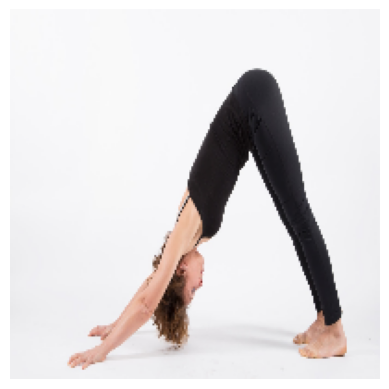

In [136]:
sample_idx = 0
plt.axis('off')
plt.imshow(dataset[sample_idx])
plt.show()

In [137]:
dataset_array = np.asarray(dataset)
canny_list = []

for sample in range(len(dataset_array)):
    gray_img = cv2.cvtColor(dataset_array[sample], cv2.COLOR_RGB2GRAY)
    new_img = skimage.feature.canny(gray_img)
    canny_list.append(new_img)

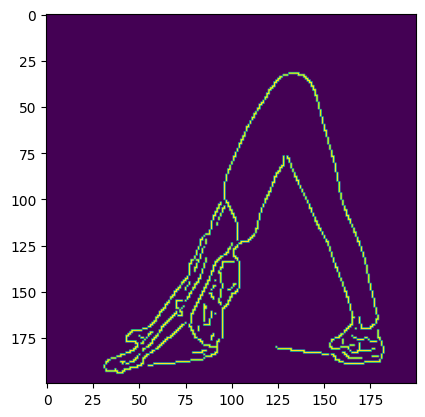

In [138]:
plt.imshow(canny_list[sample_idx])
plt.show()

In [139]:
sample = canny_list[sample_idx]
indices = list(zip(*np.where(sample == 1)))

In [140]:
list(np.mean(indices, axis=0))

[140.5797213622291, 109.36300309597523]

In [141]:
new_img = copy.deepcopy(canny_list[sample_idx])
step = 50
block_points = []

for x_block in range(0, 200, step):
    for y_block in range(0, 200, step):
        indices = list(zip(*np.where(new_img[y_block:y_block+step, x_block:x_block+step] == 1)))
        try:
            if len(indices) > 50:
                mean_indices = list(np.mean(indices, axis=0))
                block_points.append([(y_block, int(mean_indices[0])), (x_block, int(mean_indices[1]))])
        except IndexError:
            continue
block_points

[[(150, 34), (0, 42)],
 [(100, 31), (50, 37)],
 [(150, 19), (50, 24)],
 [(0, 39), (100, 31)],
 [(50, 26), (100, 22)],
 [(100, 20), (100, 14)],
 [(100, 27), (150, 13)],
 [(150, 25), (150, 17)]]

In [142]:
points = [(block_points[idx][1][0] + block_points[idx][1][1], block_points[idx][0][0] + block_points[idx][0][1]) for idx in range(len(block_points))]
points

[(42, 184),
 (87, 131),
 (74, 169),
 (131, 39),
 (122, 76),
 (114, 120),
 (163, 127),
 (167, 175)]

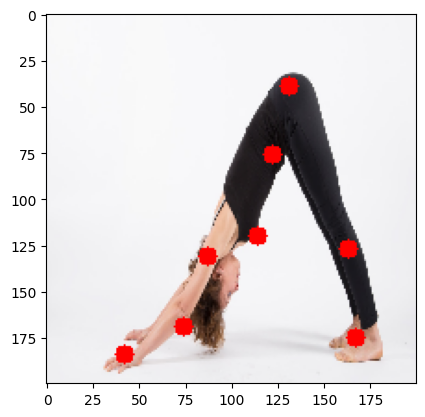

In [143]:
rgb_image = copy.deepcopy(dataset[sample_idx])
for point in points:
    rgb_image = cv2.circle(rgb_image, point, radius=5, color=(255, 0, 0), thickness=-1)
plt.imshow(rgb_image)
plt.show()

In [144]:
mass_x, mass_y = np.where(canny_list[sample_idx] == 1)
cent_x = np.average(mass_x)
cent_y = np.average(mass_y)

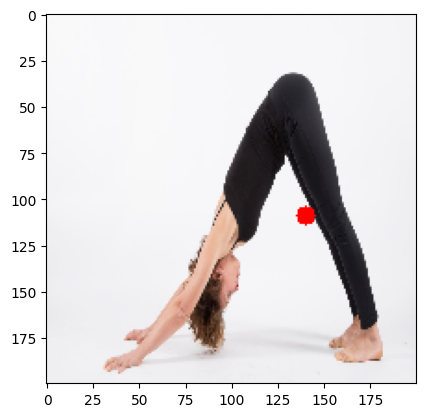

In [145]:
rgb_image = copy.deepcopy(dataset[sample_idx])
# for point in points:
rgb_image = cv2.circle(rgb_image, (int(cent_x), int(cent_y)), radius=5, color=(255, 0, 0), thickness=-1)
plt.imshow(rgb_image)
plt.show()

------------------------------------------------------------------------------------------------------------------------------------------

<center><h1> Experimenting with gaussian blur and grabcut </h1></center>

In [177]:
def show_points(sample: np.array, step: int = 50, treshold: int = 50):
    rgb_image = copy.deepcopy(sample)

    try:
        sample = cv2.cvtColor(sample, cv2.COLOR_RGB2GRAY)
    except:
        pass
    sample = skimage.feature.canny(sample)

    block_points = []

    for x_block in range(0, 200, step):
        for y_block in range(0, 200, step):
            indices = list(zip(*np.where(sample[y_block:y_block + step, x_block:x_block + step] == 1)))
            try:
                if len(indices) > treshold:
                    mean_indices = list(np.mean(indices, axis=0))
                    block_points.append([(y_block, int(mean_indices[0])), (x_block, int(mean_indices[1]))])
            except IndexError:
                continue

    points = [(block_points[idx][1][0] + block_points[idx][1][1], block_points[idx][0][0] + block_points[idx][0][1]) for idx in range(len(block_points))]

    for point in points:
        rgb_image = cv2.circle(rgb_image, point, radius=5, color=(255, 0, 0), thickness=-1)
    plt.imshow(rgb_image)
    plt.show()

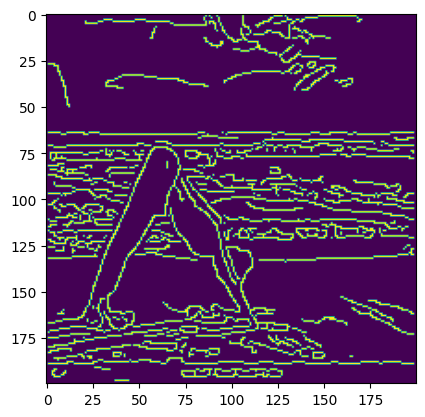

In [178]:
plt.imshow(canny_list[sample_idx])
plt.show()

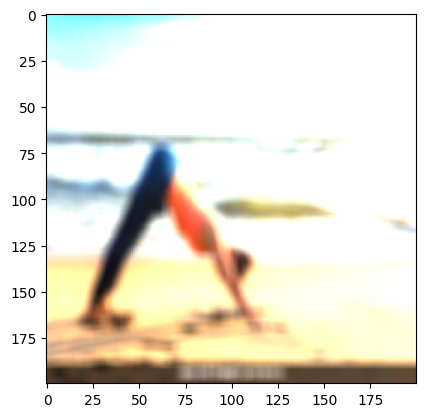

In [179]:
sample_idx = 290
# filtered_img = skimage.filters.gaussian(dataset[sample_idx], sigma=3, channel_axis=-1)

kernel = np.ones((7,7), np.float32) / 25
dst = cv2.filter2D(dataset[sample_idx], -1, kernel)
plt.imshow(dst)
plt.show()

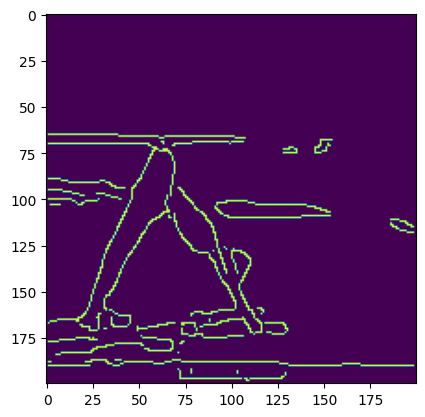

In [180]:
filtered_img = cv2.cvtColor(dst, cv2.COLOR_RGB2GRAY)
plt.imshow(skimage.feature.canny(filtered_img))
plt.show()

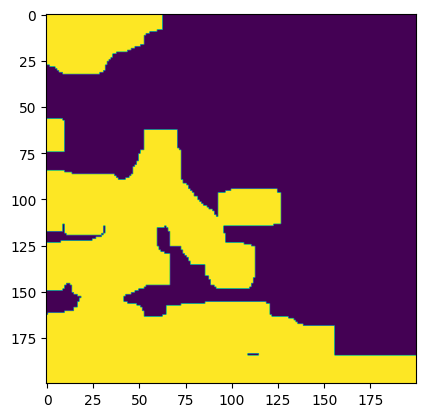

In [181]:
# grabcut needs tuning but may be useful for character extraction
PATH = '../../data/DATASET/downdog/00000376.jpg'
gaussian_kernel = np.ones((5,5), np.float32) / 25

gray_sample = cv2.imread(PATH, cv2.IMREAD_GRAYSCALE)
gray_sample = cv2.resize(gray_sample, (200, 200))
gray_sample = cv2.filter2D(gray_sample, -1, gaussian_kernel)

kernel = np.ones((5,5), np.uint8)
closing = cv2.morphologyEx(gray_sample, cv2.MORPH_CLOSE, kernel, iterations=3)
erosion = cv2.morphologyEx(closing, cv2.MORPH_ERODE, kernel, iterations=1)

mask = np.zeros(sample.shape[:2], np.uint8)
mask[:] = 2
mask[erosion >= 150]= 1
bgdmodel = np.zeros((1, 65), np.float64)
fgdmodel = np.zeros((1, 65), np.float64)

sample = cv2.imread(PATH, cv2.IMREAD_COLOR)
sample = cv2.resize(sample, (200, 200))
sample = cv2.filter2D(sample, -1, gaussian_kernel)

out_mask = mask.copy()
out_mask, _, _ = cv2.grabCut(sample, out_mask, None, bgdmodel, fgdmodel, 1, cv2.GC_INIT_WITH_MASK)
out_mask = np.where((out_mask==2)|(out_mask==0),0,1).astype('uint8')
out_img = sample * out_mask[:,:,np.newaxis]
plt.imshow(mask)
plt.show()

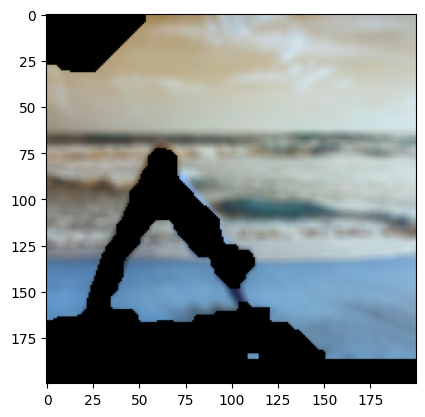

In [182]:
plt.imshow(out_img)
plt.show()

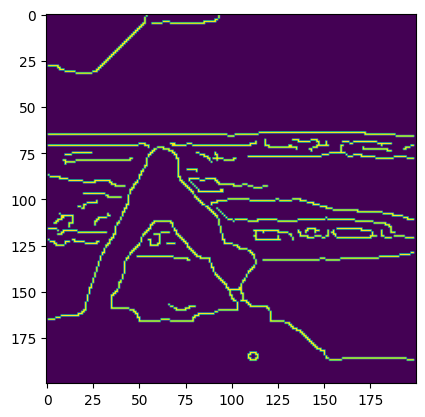

In [183]:
out_img = cv2.cvtColor(out_img, cv2.COLOR_RGB2GRAY)
plt.imshow(skimage.feature.canny(out_img))
plt.show()

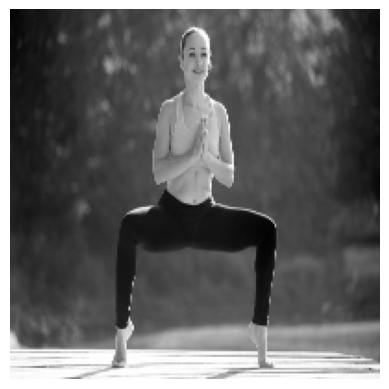

In [184]:
gaussian_kernel = np.ones((5,5), np.float32) / 25

# for idx in range(20):
out_img = cv2.cvtColor(dataset[504], cv2.COLOR_BGR2GRAY)
# out_img = cv2.filter2D(out_img, -1, gaussian_kernel)
# out_img = skimage.feature.canny(out_img)

plt.axis('off')
plt.imshow(out_img, cmap='gray')
plt.show()

--------------------------------------------------------------------------------------------------------------------------------

<center><h1> Building forest model </h1></center>

In [169]:
def produce_dots(sample: np.array, step: int = 50, treshold: int = 50, kernel_size: int = 5, kernel_strength: int = 25, cut_out: bool = False):
    too_many_dots = False
    pointed_output = np.zeros_like(sample)
    kernel = np.ones((kernel_size, kernel_size), np.float32) / kernel_strength
    sample = cv2.filter2D(sample, -1, kernel)

    try:
        sample = cv2.cvtColor(sample, cv2.COLOR_RGB2GRAY)
    except:
        pass

    sample = skimage.feature.canny(sample)

    block_points = []

    for x_block in range(0, 200, step):
        for y_block in range(0, 200, step):
            indices = list(zip(*np.where(sample[y_block:y_block + step, x_block:x_block + step] == 1)))
            try:
                if len(indices) > treshold:
                    mean_indices = list(np.mean(indices, axis=0))
                    block_points.append([(y_block, int(mean_indices[0])), (x_block, int(mean_indices[1]))])
            except IndexError:
                continue

    points = [(block_points[idx][1][0] + block_points[idx][1][1], block_points[idx][0][0] + block_points[idx][0][1]) for idx in range(len(block_points))]

    if cut_out:
        if len(points) > 11 or len(points) < 4:
            too_many_dots = True
            return pointed_output, len(points), too_many_dots

    for point in points:
        pointed_output = cv2.circle(pointed_output, point, radius=5, color=(255, 0, 0), thickness=-1)

    pointed_output = cv2.cvtColor(pointed_output, cv2.COLOR_RGB2GRAY)
    return pointed_output, len(points), too_many_dots

In [156]:
pointed_images = []
length_of_points = []
flags = []
for image in dataset:
    pointed_output, length_of_point, flag = produce_dots(image, step=50, treshold=50, kernel_size=6, kernel_strength=25, cut_out=True)
    pointed_images.append(pointed_output)
    length_of_points.append(length_of_point)
    flags.append(flag)

In [170]:
def cut_out_samples(pointed_images: list, labels: list, flags: list):
    new_pointed_images = []
    new_labels = []

    for idx in range(len(flags)):
        if not flags[idx]:
            new_pointed_images.append(pointed_images[idx])
            new_labels.append(labels[idx])

    return new_pointed_images, new_labels

In [158]:
pointed_images, new_labels = cut_out_samples(pointed_images, labels)

In [159]:
# from collections import Counter
# plt.hist(length_of_points, bins=len(Counter(length_of_points)))

In [160]:
dataset_array = np.asarray(pointed_images)
labels_array = np.asarray(labels)
labels_encoded = OneHotEncoder().fit_transform(np.reshape(labels_array, newshape=(len(labels_array), 1))).toarray()

In [161]:
dataset_array = dataset_array.reshape((dataset_array.shape[0], dataset_array.shape[1] * dataset_array.shape[2]))

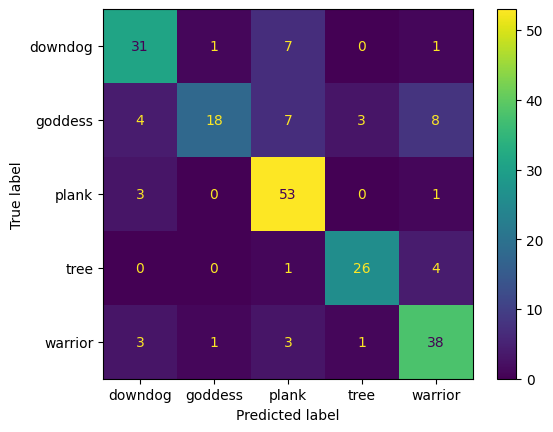

In [162]:
PATH = "C:/Users/cubix/Desktop/analiza-obrazow-cyfrowych-projekt/data/DATASET/"

X_train, X_test, y_train, y_test = train_test_split(dataset_array, labels_array, test_size=0.2)
tree = RandomForestClassifier().fit(X_train, y_train)
y_pred = tree.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
display = ConfusionMatrixDisplay(cm, display_labels=os.listdir(PATH))
display.plot()
plt.show()

In [163]:
print(balanced_accuracy_score(y_test, y_pred))

0.7639242390689207


In [ ]:
dataset = []
labels = []

for classes in os.listdir(PATH):
    for image in os.listdir(PATH + classes):
        img = cv2.imread(PATH + classes + '/' + image, cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        resized = cv2.resize(img, (200, 200))
        dataset.append(resized)
        labels.append(classes)

In [174]:
step = [25, 50, 60, 75]
treshold = [50, 60, 70]
kernel_size = [5, 6, 7]

scores = dict()

for stp in step:
    for trsh in treshold:
        for ks in kernel_size:

            pointed_images = []
            flags = []
            for image in dataset:
                pointed_output, _, flag = produce_dots(image, step=stp, treshold=trsh, kernel_size=ks, kernel_strength=25, cut_out=True)
                pointed_images.append(pointed_output)
                flags.append(flag)

            pointed_images, new_labels = cut_out_samples(pointed_images, labels, flags)

            dataset_array = np.asarray(pointed_images)
            labels_array = np.asarray(new_labels)
            labels_encoded = OneHotEncoder().fit_transform(np.reshape(labels_array, newshape=(len(labels_array), 1))).toarray()

            dataset_array = dataset_array.reshape((dataset_array.shape[0], dataset_array.shape[1] * dataset_array.shape[2]))

            X_train, X_test, y_train, y_test = train_test_split(dataset_array, labels_array, test_size=0.2)
            tree = RandomForestClassifier().fit(X_train, y_train)
            y_pred = tree.predict(X_test)
            scores[(stp, trsh, ks)] = balanced_accuracy_score(y_test, y_pred)
            print('Done')

Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done


In [175]:
max(scores.values())

0.7871446969019107

In [176]:
scores

{(25, 50, 5): 0.6908709808709809,
 (25, 50, 6): 0.7241436994378171,
 (25, 50, 7): 0.7395238095238096,
 (25, 60, 5): 0.756256157635468,
 (25, 60, 6): 0.682067542080353,
 (25, 60, 7): 0.5592914438502674,
 (25, 70, 5): 0.6086009852216749,
 (25, 70, 6): 0.5440914158305462,
 (25, 70, 7): 0.5234593837535013,
 (50, 50, 5): 0.7871446969019107,
 (50, 50, 6): 0.7516579254079254,
 (50, 50, 7): 0.6591818207914415,
 (50, 60, 5): 0.7546315185749829,
 (50, 60, 6): 0.7391030909832006,
 (50, 60, 7): 0.655594651653765,
 (50, 70, 5): 0.762161753590325,
 (50, 70, 6): 0.710408886465858,
 (50, 70, 7): 0.6505921052631579,
 (60, 50, 5): 0.6764136433023404,
 (60, 50, 6): 0.6613729722658294,
 (60, 50, 7): 0.6336224744770471,
 (60, 60, 5): 0.7603008511096746,
 (60, 60, 6): 0.6751506523662096,
 (60, 60, 7): 0.6204194018181539,
 (60, 70, 5): 0.7394328705809574,
 (60, 70, 6): 0.674886101586512,
 (60, 70, 7): 0.6025588486096379,
 (75, 50, 5): 0.6352931488801055,
 (75, 50, 6): 0.6644040812014093,
 (75, 50, 7): 0.6700